# Simpler case: ignore noise

$$
\begin{align}
\text{MI}(Y;N) &= \sum_{n} p_N(n) \sum_{y} p_{Y|N}(y|n,\theta) \left( \log p_{Y|N}(y|n, \theta) - \log p_Y(y | \theta) \right) \\
&= - \sum_{n} p_N(n) \log p_Y(\hat y(n, \theta) | \theta) = - \sum_{n} p_N(n) \log \left( \sum_{k: \hat y(n, \theta) = \hat y(k, \theta)} p_N(k)\right) \\ 
&= - \sum_{s\in \Chi} p_S(s|\theta) \log p_S(s|\theta) \\
\text{ where } p_S(s|\theta) &= \sum_{k \in s} p_N(k) \\ 
\text{ and } \Chi =& \{\hat y^{-1}(y, \theta) : y \in \{0,2^B-1\}\}\\ 
\end{align}
$$

For evenly $K$ spaced bins with spacing $\alpha$ starting at $\beta$ plus one bin stretching to infinity in each direction, and enumerating these bins from left to right, we have $p_S(s_i) = \sum_{k \in s_i} p_N(k)$ where $s_0 = \{ -\infty, ..., \lfloor \beta \rfloor \}$, $s_i = \{ \lceil \beta + \alpha(i-1) \rceil, ..., \lfloor \beta + \alpha i \rfloor \}$ for $i = 1, ..., K$, and $s_{K+1} = \{ \lceil \beta + \alpha K \rceil, \infty \}$.

Hence the probabilities are $p_S(s_0) = F_N(\lfloor \beta \rfloor)$, $p_S(s_i) = F_N(\lfloor \beta + \alpha i \rfloor) - F_N(\lceil \beta + \alpha(i-1) \rceil)$ for $i = 1, ..., K$, and $p_S(s_{K+1}) = 1 - F_N(\lceil \beta + \alpha K \rceil)$.

In [1]:
import __init__
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
from adim import *
plt.style.use('ggplot')

Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


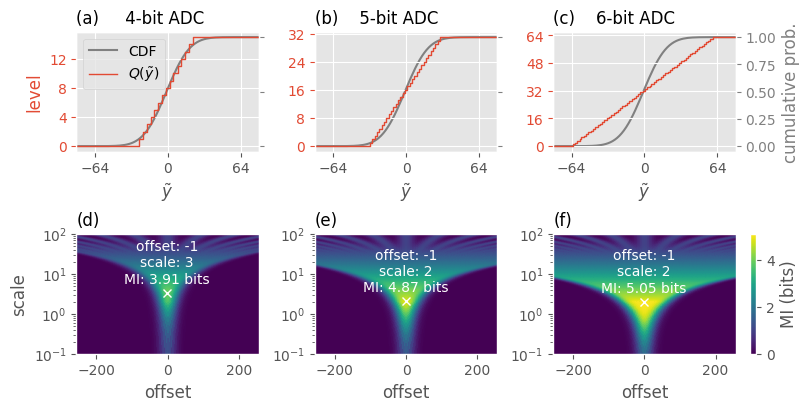

In [13]:

# create the figure
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
# share_axis(ax[:,:-1], sharex="row", sharey="row")

vector_length = 256
d = dists.Binomial(vector_length, 0.5)
support = jnp.array(d.enumerate_support())*2 - vector_length
probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

phase = jnp.linspace(-vector_length, vector_length, 1000)
scale = jnp.logspace(-1, 2, 1000)


vmin, vmax = 0, jnp.log2(4*jnp.pi*jnp.e)

cases = [("(a)     4-bit ADC", "(d)", 4),("(b)    5-bit ADC", "(e)", 5),("(c)    6-bit ADC", "(f)", 6)]
for i,(label1, label2, bits) in enumerate(cases):
    # compute MI for different scales and phases
    MIs = MI_nonoise(*jnp.ix_(scale, phase), 2**bits, support, probabilities)
    
    # compute optimum
    max_idx = MIs.argmax()
    max_scale_idx, max_phase_idx = jnp.unravel_index(max_idx, MIs.shape)
    max_scale = scale[max_scale_idx]
    max_phase = phase[max_phase_idx]
    max_MI = MIs[max_scale_idx, max_phase_idx]

    ax_cdf, ax_fun, lines = plot_quantization(ax[0,i], vector_length, bits, max_scale, max_phase, color=f"C0", yticklocator=MultipleLocator(2**(bits-2)))
    ax_sweep, im = plot_sweep(ax[1,i], phase, scale, MIs, annotate=(max_phase, max_scale, max_MI), vmin=vmin, vmax=vmax, cmap="viridis", rasterized=True)
    
    if i != 0:
        ax_fun.yaxis.label.set_visible(False)

    if i == 2:
        ax_cdf.yaxis.label.set_visible(True)
        ax_cdf.set_yticks([0,0.25,0.5,0.75,1.0])
    else:
        ax_cdf.yaxis.label.set_visible(False)
        plt.setp(ax_cdf.get_yticklabels(), visible=False)

    # im = plot_sweep()

    labels = [l.get_label() for l in lines]

    ax_fun.set_xlim(-80,80)
    ax_fun.set_title(label1, fontsize=12, loc="left")
    ax_sweep.set_title(label2, fontsize=12, loc="left")
    ax_sweep.set_xlabel("offset")

    if i == 0:
        ax_fun.legend(handles=lines, labels=labels, loc="upper left", fancybox=True, ncol=1)
    

fig.colorbar(im, ax=ax[1,:], label="MI (bits)", pad=-0.075)
# place legend in axis, hide everything else
# ax[0,-1].axis("off")

ax[1, 0].set_ylabel("scale")

fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
fig.savefig("../figures/optimum.svg", bbox_inches="tight")
fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)

In [4]:
ax[1,2].transAxes

In [7]:
# plot vector length vs number of ADC bits, offset and scale

from tqdm import tqdm

# phase offset can be -1, -0.5, or 0 (we started with centered bins)
phase = jnp.array([-1, -0.5, 0])
scale = jnp.logspace(-1, 2, 1000)

vector_length = 2**jnp.arange(1, 16.1, 0.125)
enobs = []
cases = [("low-res.", -1), ("mid-res.", 0), ("high-res.", 1)]
max_MIs = [[] for _ in range(len(cases))]
num_bits = [[] for _ in range(len(cases))]
max_scales = [[] for _ in range(len(cases))]
max_phases = [[] for _ in range(len(cases))]
max_ranges = [[] for _ in range(len(cases))]
max_widths = [[] for _ in range(len(cases))]

for vl in tqdm(vector_length):
    # generate distribution for given vector length
    d = dists.Binomial(vl, 0.5)
    support = jnp.array(d.enumerate_support())*2 - vl
    probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

    # compute ENOB
    ENOB = enob(vl)
    enobs.append(ENOB)

    # low bit-precision is rounded down, high bit-precision is rounded up
    for i,bits in enumerate([int(ENOB) + o for (_,o) in cases]):

        # compute MI for low and high precision
        MIs = MI_nonoise(*jnp.ix_(scale, phase), 2**bits, support, probabilities)

        # find location of the maximum MI for low precision    
        max_idx= MIs.argmax()
        max_scale_idx, max_phase_idx= jnp.unravel_index(max_idx, MIs.shape)
        max_scale= scale[max_scale_idx]
        max_phase= phase[max_phase_idx]
        max_MI= MIs[max_scale_idx, max_phase_idx]

        # compute which range the central bins cover
        covered_range= max_scale* (2**bits - 1)

        # compute how many numbers fall within each central bin
        offset_fixed = (support[0] + support[-1]) / 2
        levels= compute_even_levels(2**bits, max_scale, max_phase, offset_fixed=offset_fixed).squeeze()
        (vals, counts) = jnp.unique_counts(jnp.searchsorted(levels, support))
        max_width= jnp.sum(counts, where=(vals > 1) & (vals < (2**bits)-2)) / (2**bits - 2)

        # track results
        num_bits[i].append(int(bits))
        max_MIs[i].append(float(max_MI))
        max_scales[i].append(float(max_scale))
        max_ranges[i].append(float(covered_range))
        max_widths[i].append(float(max_width))

num_bits = jnp.array(num_bits)
max_MIs = jnp.array(max_MIs)
max_scales = jnp.array(max_scales)
max_phases = jnp.array(max_phases)
max_ranges = jnp.array(max_ranges)
max_widths = jnp.array(max_widths)


100%|██████████| 121/121 [01:18<00:00,  1.55it/s]


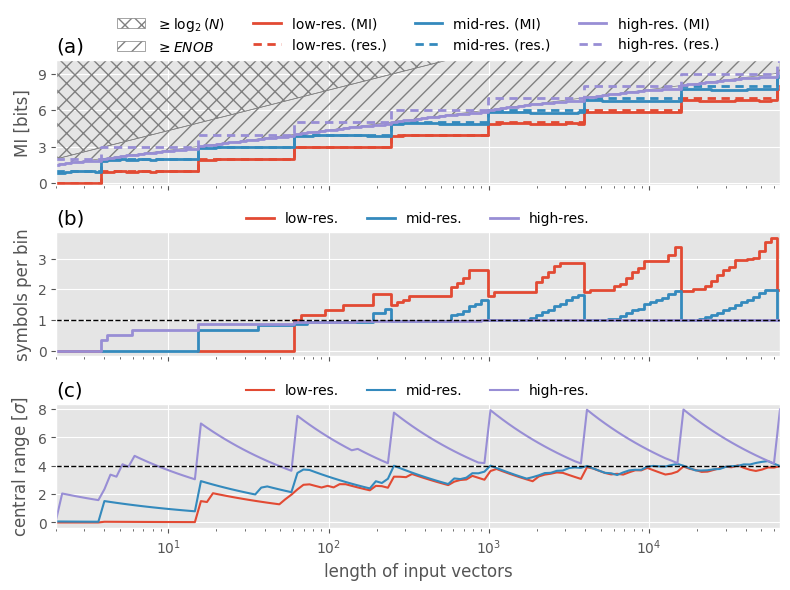

In [8]:
from matplotlib.ticker import MaxNLocator


fig, (ax_MI, ax_scales, ax_range) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ymin, ymax = -0.1, 10.1
xmin, xmax = vector_length[0], vector_length[-1]
    
# hatch the completely unachievable region
ax_MI.fill_between(
    vector_length,
    1 + jnp.log2(vector_length),
    jnp.zeros_like(vector_length) + ymax,
    label="$\\geq\\log_2(N)$",
    edgecolor="gray",
    facecolor="none",
    hatch="XX",
)

# hatch the unachievable region > ENOB
ax_MI.fill_between(
    vector_length,
    1 + jnp.log2(vector_length),
    enobs,
    label="$\\geq ENOB$",
    edgecolor="gray",
    facecolor="none",
    hatch="//",
)

# plot the individual results for each case
for i, (label1, offset) in enumerate(cases):
    # plot the limit and measured MI
    ax_MI.step(
        vector_length, 
        max_MIs[i], 
        label=f"{label1} (MI)", 
        where="mid", 
        color=f"C{i}", 
        lw=2
    )
    
    ax_MI.step(
        vector_length,
        num_bits[i],
        "--",
        dashes = [3,2],
        label=f"{label1} (res.)",
        where="mid",
        color=f"C{i}",
        lw=2,
    )

    # plot the average number of values that fall within the central bins
    ax_scales.step(vector_length, max_widths[i], where="mid", label=label1, color=f"C{i}", lw=2)

    # plot the covered range of the central bins in standard deviations
    ax_range.plot(vector_length, jnp.array(max_ranges[i]) / jnp.sqrt(vector_length), label=label1)

ax_MI.set_xscale("log")
ax_MI.set_ylabel("MI [bits]")
ax_MI.set_ylim(ymin, ymax)
ax_MI.set_xlim(xmin, xmax)

ax_scales.hlines([1.0], xmin, xmax, lw=1, linestyles="--", color="black")
ax_scales.set_ylabel("symbols per bin")

ax_range.hlines([4.0], xmin, xmax, lw=1, linestyles="--", color="black")
ax_range.set_xlabel("length of input vectors")
ax_range.set_ylabel("central range [$\\sigma$]")

# set integer locators for each plot
ax_MI.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax_scales.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax_range.yaxis.set_major_locator(MaxNLocator(5, integer=True))

ax_MI.set_title("(a)", loc="left")
ax_scales.set_title("(b)", loc="left")
ax_range.set_title("(c)", loc="left")

ax_MI.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=4)
ax_scales.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=3)
ax_range.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=3)

fig.tight_layout()

fig.savefig("../figures/range.pdf", bbox_inches="tight")
fig.savefig("../figures/range.svg", bbox_inches="tight")
fig.savefig("../figures/range.png", bbox_inches="tight", dpi=300)